In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Add top5 accuracy and test the models.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import torch.optim as optim
import timm 

import torch.nn as nn
import os, torch, shutil, numpy as np
from glob import glob; from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(2024)
import random
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.optim as optim
from sklearn.metrics import f1_score
import torch.nn.functional as F

from torchvision import models
from sklearn.metrics import top_k_accuracy_score


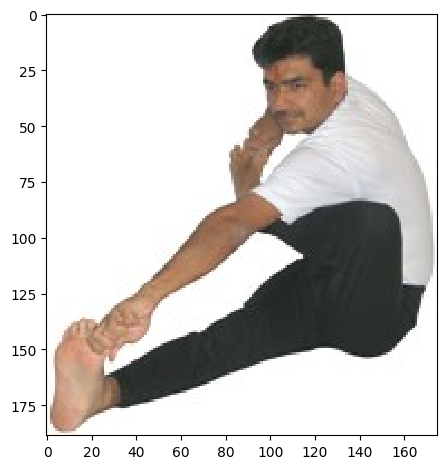

In [3]:
img_path = "/kaggle/input/yoga-82/train/Akarna_Dhanurasana/Akarna_Dhanurasana_image_11.jpg"
image = imread(img_path)
imshow(image)

## Load the dataset and transform it to tensors

In [4]:
train_path = "../input/yoga-82/train"
valid_path = "../input/yoga-82/valid"
test_path = "../input/yoga-82/test"

batch size 128 currently

In [5]:
torch.manual_seed(2024)

class CustomDataset(Dataset):
    def __init__(self, root, transformations = None):
        
        self.transformations = transformations
        self.im_paths = sorted(glob(f"{root}/*/*"))
        
        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        for idx, im_path in enumerate(self.im_paths):
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names: self.cls_names[class_name] = count; self.cls_counts[class_name] = 1; count += 1
            else: self.cls_counts[class_name] += 1
    def get_class(self, path): return os.path.dirname(path).split("/")[-1]
    
    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):
        
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB") 
        gt = self.cls_names[self.get_class(im_path)]
        
        if self.transformations is not None: im = self.transformations(im)
        
        return im, gt
    
def get_dls(root, transformations, bs, ns = 4):
    tr_ds, vl_ds, ts_ds = CustomDataset(root = root + "/train", transformations = transformations), CustomDataset(root = root + "/valid", transformations = transformations), CustomDataset(root = root + "/test", transformations = transformations)

    tr_dl, val_dl, ts_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, num_workers = ns), DataLoader(vl_ds, batch_size = bs, shuffle = False, num_workers = ns), DataLoader(ts_ds, batch_size = 1, shuffle = False, num_workers = ns)

    return tr_dl, val_dl, ts_dl, tr_ds.cls_names

root = "/kaggle/input/yoga-82"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root = root, transformations = tfs, bs = 128)

#tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor()])
#tr_dl, val_dl, ts_dl, classes = get_dls(root = root, transformations = tfs, bs = 32)

print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes) #for batch size 32

92
27
1764
{'Akarna_Dhanurasana': 0, 'Bharadvajas_Twist_pose_or_Bharadvajasana_I_': 1, 'Boat_Pose_or_Paripurna_Navasana_': 2, 'Bound_Angle_Pose_or_Baddha_Konasana_': 3, 'Bow_Pose_or_Dhanurasana_': 4, 'Bridge_Pose_or_Setu_Bandha_Sarvangasana_': 5, 'Camel_Pose_or_Ustrasana_': 6, 'Cat_Cow_Pose_or_Marjaryasana_': 7, 'Chair_Pose_or_Utkatasana_': 8, 'Child_Pose_or_Balasana_': 9, 'Cobra_Pose_or_Bhujangasana_': 10, 'Cockerel_Pose': 11, 'Corpse_Pose_or_Savasana_': 12, 'Cow_Face_Pose_or_Gomukhasana_': 13, 'Crane_(Crow)_Pose_or_Bakasana_': 14, 'Dolphin_Plank_Pose_or_Makara_Adho_Mukha_Svanasana_': 15, 'Dolphin_Pose_or_Ardha_Pincha_Mayurasana_': 16, 'Downward-Facing_Dog_pose_or_Adho_Mukha_Svanasana_': 17, 'Eagle_Pose_or_Garudasana_': 18, 'Eight-Angle_Pose_or_Astavakrasana_': 19, 'Extended_Puppy_Pose_or_Uttana_Shishosana_': 20, 'Extended_Revolved_Side_Angle_Pose_or_Utthita_Parsvakonasana_': 21, 'Extended_Revolved_Triangle_Pose_or_Utthita_Trikonasana_': 22, 'Feathered_Peacock_Pose_or_Pincha_Mayurasan

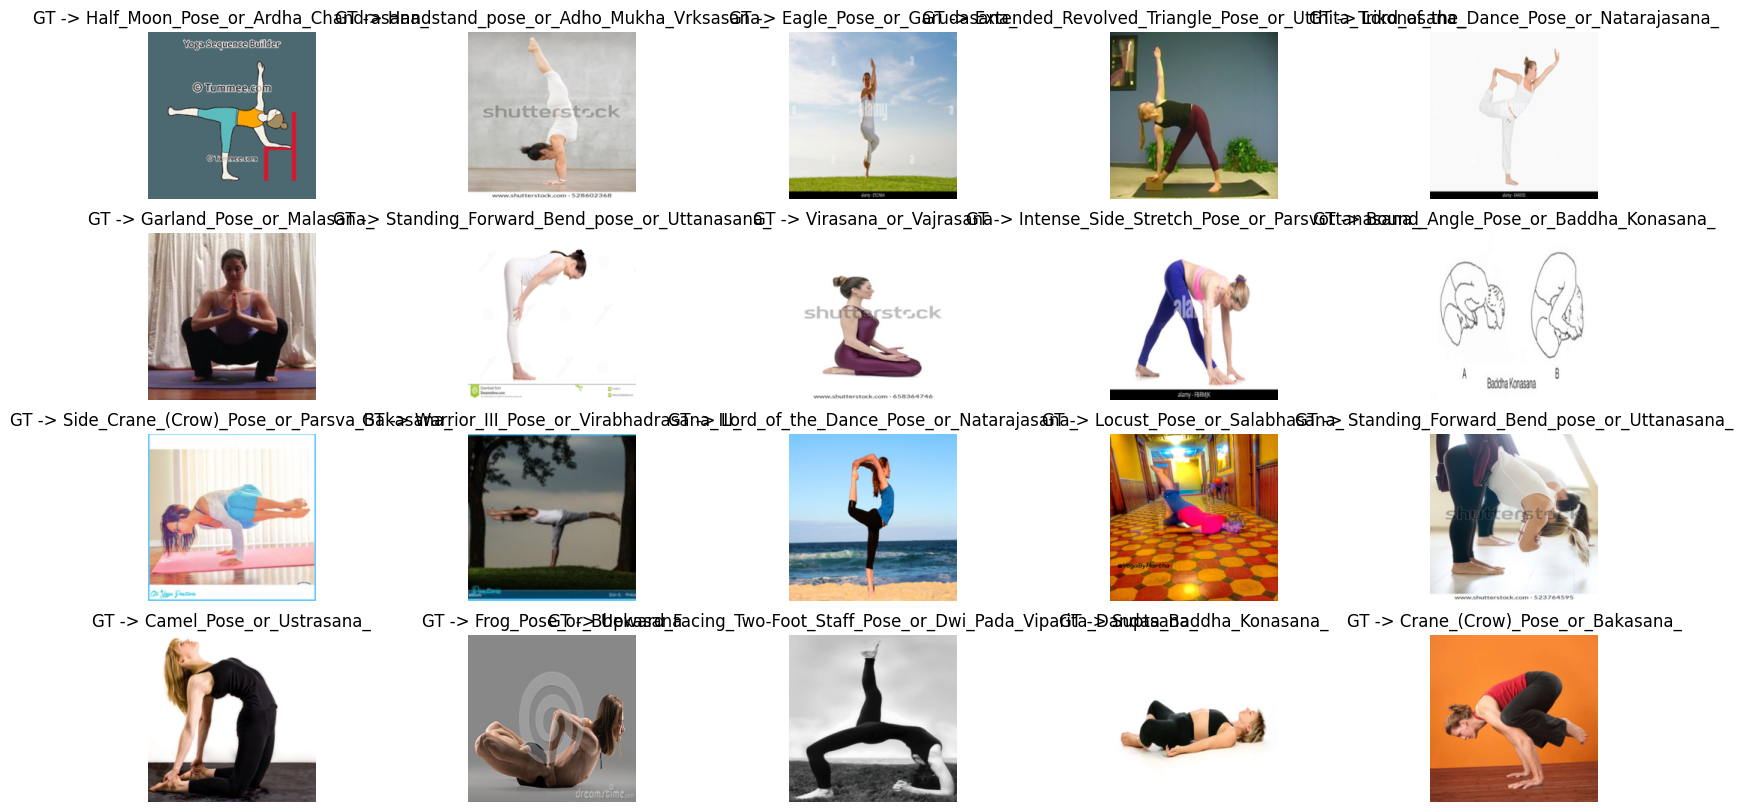

In [6]:
## visualization
def tensor_2_im(t, t_type = "rgb"):
    
    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
    
    invTrans = gray_tfs if t_type == "gray" else rgb_tfs 
    
    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):
    
    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):
        
        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")
            
visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

## DENSENET 201


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

batch size 128

top 5

In [ ]:
# Load the pre-trained DenseNet201 model
model = models.densenet201(weights=True)
model = model.to(device)

# Freeze the parameters
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier layer
num_classes = 82
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Define the scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True, threshold=0.01)

num_epochs = 100

# Early stopping parameters
early_stopping_patience = 5
best_val_loss = np.inf
epochs_no_improve = 0

for epoch in range(num_epochs):
    # Training Loop
    model.train()
    running_loss = 0.0
    correct_train = 0
    correct_train_top5 = 0  # Track top-5 correct predictions
    total_train = 0
    train_labels = []
    train_preds = []
    
    for inputs, labels in tr_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Collect true labels and predictions
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Top-5 accuracy calculation
        top5_pred = torch.topk(outputs, 5, dim=1).indices
        correct_train_top5 += torch.sum(top5_pred.eq(labels.view(-1, 1)).any(dim=1)).item()

        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(predicted.cpu().numpy())

    # Validation Loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    correct_val_top5 = 0  # Track top-5 correct predictions
    total_val = 0
    val_labels = []
    val_preds = []
    
    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Collect true labels and predictions
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            # Top-5 accuracy calculation
            top5_pred = torch.topk(outputs, 5, dim=1).indices
            correct_val_top5 += torch.sum(top5_pred.eq(labels.view(-1, 1)).any(dim=1)).item()

            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Compute metrics
    val_loss /= len(val_dl)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * correct_val / total_val
    train_top5_accuracy = 100 * correct_train_top5 / total_train  # Train top-5 accuracy
    val_top5_accuracy = 100 * correct_val_top5 / total_val        # Val top-5 accuracy
    
    train_f1 = f1_score(train_labels, train_preds, average='macro')
    val_f1 = f1_score(val_labels, val_preds, average='macro')

    # Step the scheduler based on the validation loss
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {running_loss/len(tr_dl):.4f}, "
          f"Training Accuracy: {train_accuracy:.2f}%, "
          f"Training Top-5 Accuracy: {train_top5_accuracy:.2f}%, "
          f"Training F1 Score: {train_f1:.2f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%, "
          f"Validation Top-5 Accuracy: {val_top5_accuracy:.2f}%, "
          f"Validation F1 Score: {val_f1:.2f}")
    
    for param_group in optimizer.param_groups:
        print(f"Epoch {epoch+1}: Learning rate is {param_group['lr']}")
    
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'densenet_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break  # Stop training

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 176MB/s] 


Epoch 1/100, Training Loss: 4.3091, Training Accuracy: 3.85%, Training Top-5 Accuracy: 13.81%, Training F1 Score: 0.01, Validation Loss: 4.2044, Validation Accuracy: 6.62%, Validation Top-5 Accuracy: 21.75%, Validation F1 Score: 0.02
Epoch 1: Learning rate is 0.001
Epoch 2/100, Training Loss: 4.0697, Training Accuracy: 11.05%, Training Top-5 Accuracy: 29.56%, Training F1 Score: 0.05, Validation Loss: 4.0296, Validation Accuracy: 12.32%, Validation Top-5 Accuracy: 34.59%, Validation F1 Score: 0.05
Epoch 2: Learning rate is 0.001
Epoch 3/100, Training Loss: 3.8801, Training Accuracy: 16.73%, Training Top-5 Accuracy: 40.95%, Training F1 Score: 0.08, Validation Loss: 3.8790, Validation Accuracy: 17.64%, Validation Top-5 Accuracy: 43.03%, Validation F1 Score: 0.09
Epoch 3: Learning rate is 0.001
Epoch 4/100, Training Loss: 3.7041, Training Accuracy: 22.89%, Training Top-5 Accuracy: 49.10%, Training F1 Score: 0.12, Validation Loss: 3.7379, Validation Accuracy: 20.20%, Validation Top-5 Accura

KeyboardInterrupt: 

## Additional Layers

In [ ]:
# Download the pre-trained DenseNet201 model and send it to the device
model = models.densenet201(weights=True)
model = model.to(device)

# Freeze the parameters of the base model
for param in model.parameters():
    param.requires_grad = False

# Modify the fully connected layer to add custom layers
num_ftrs = model.classifier.in_features  # number of units in the final fully connected layer of DenseNet
num_classes = 82  

# Create a new fully connected block with Flatten, Dense, BatchNorm, Dropout
model.classifier = nn.Sequential(
    nn.Flatten(),                 # Flatten the output
    nn.Linear(num_ftrs, 256),     # Dense layer with 256 units
    nn.ReLU(),                    # Activation function
    nn.BatchNorm1d(256),          # Batch normalization
    nn.Dropout(0.5),              # Dropout with 50% probability
    nn.Linear(256, num_classes),  # Output layer with num_classes units
    nn.Softmax(dim=1)             # Softmax activation for classification
)
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)

# Early stopping parameters
early_stopping_patience = 5  # Number of epochs to wait before stopping
best_val_loss = np.inf       # Set initial best validation loss to infinity
epochs_no_improve = 0        # Counter for epochs without improvement

num_epochs = 40

for epoch in range(num_epochs):
    # Training Loop
    model.train()
    running_loss = 0.0
    correct_train = 0
    correct_train_top5 = 0  # Track top-5 correct predictions for training
    total_train = 0
    train_labels = []
    train_preds = []
    
    for inputs, labels in tr_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Collect true labels and predictions for top-1 accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Top-5 accuracy calculation
        top5_pred = torch.topk(outputs, 5, dim=1).indices
        correct_train_top5 += torch.sum(top5_pred.eq(labels.view(-1, 1)).any(dim=1)).item()

        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(predicted.cpu().numpy())

    # Validation Loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    correct_val_top5 = 0  # Track top-5 correct predictions for validation
    total_val = 0
    val_labels = []
    val_preds = []
    
    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Collect true labels and predictions for top-1 accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            # Top-5 accuracy calculation
            top5_pred = torch.topk(outputs, 5, dim=1).indices
            correct_val_top5 += torch.sum(top5_pred.eq(labels.view(-1, 1)).any(dim=1)).item()

            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Compute metrics
    val_loss /= len(val_dl)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * correct_val / total_val
    train_top5_accuracy = 100 * correct_train_top5 / total_train  # Train top-5 accuracy
    val_top5_accuracy = 100 * correct_val_top5 / total_val        # Val top-5 accuracy
    
    train_f1 = f1_score(train_labels, train_preds, average='macro')
    val_f1 = f1_score(val_labels, val_preds, average='macro')

    # Output the metrics for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {running_loss/len(tr_dl):.4f}, "
          f"Training Accuracy: {train_accuracy:.2f}%, "
          f"Training Top-5 Accuracy: {train_top5_accuracy:.2f}%, "
          f"Training F1 Score: {train_f1:.2f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%, "
          f"Validation Top-5 Accuracy: {val_top5_accuracy:.2f}%, "
          f"Validation F1 Score: {val_f1:.2f}")
    
    for param_group in optimizer.param_groups:
        print(f"Epoch {epoch+1}: Learning rate is {param_group['lr']}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'densenetlayers_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break  # Stop training

## Vgg with additional layers


In [ ]:
# Define the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained VGG16 model
vgg_model = models.vgg16(weights='IMAGENET1K_V1')
vgg_model = vgg_model.to(device)

# Freeze all layers in the pre-trained model
for param in vgg_model.parameters():
    param.requires_grad = False

# Modify the classifier to add custom layers
num_ftrs = 512 * 7 * 7  # Number of units from the output of the convolutional layers in VGG16
num_classes = 82  # Number of classes

# Create a new fully connected block with Flatten, Dense, BatchNorm, Dropout
vgg_model.classifier = nn.Sequential(
    nn.Flatten(),                 # Flatten the output
    nn.Linear(num_ftrs, 256),     # Dense layer with 256 units
    nn.ReLU(),                    # Activation function
    nn.BatchNorm1d(256),          # Batch normalization
    nn.Dropout(0.5),              # Dropout with 50% probability
    nn.Linear(256, num_classes),  # Output layer with num_classes units
    nn.Softmax(dim=1)             # Softmax activation for classification
)
vgg_model = vgg_model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
#optimizer = optim.SGD(vgg_model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)
optimizer = torch.optim.Adam(vgg_model.parameters(), lr=3e-4, weight_decay=1e-5)

# Scheduler (optional)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True, threshold=0.01)

# Early Stopping
early_stopping_patience = 5
best_val_loss = np.inf
epochs_no_improve = 0

num_epochs = 25

for epoch in range(num_epochs):
    # Training Loop
    vgg_model.train()
    running_loss = 0.0
    correct_train = 0
    correct_top5_train = 0
    total_train = 0
    train_labels = []
    train_preds = []
    
    for inputs, labels in tr_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = vgg_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Collect true labels and predictions
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(predicted.cpu().numpy())
        
        # Calculate Top-5 Accuracy for training
        _, top5_predicted = torch.topk(outputs, 5, dim=1)
        correct_top5_train += torch.eq(top5_predicted, labels.view(-1, 1)).sum().item()

    # Validation Loop
    vgg_model.eval()
    val_loss = 0.0
    correct_val = 0
    correct_top5_val = 0
    total_val = 0
    val_labels = []
    val_preds = []
    
    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = vgg_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Collect true labels and predictions
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())
            
            # Calculate Top-5 Accuracy for validation
            _, top5_predicted = torch.topk(outputs, 5, dim=1)
            correct_top5_val += torch.eq(top5_predicted, labels.view(-1, 1)).sum().item()

    # Compute metrics
    val_loss /= len(val_dl)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * correct_val / total_val
    top5_train_accuracy = 100 * correct_top5_train / total_train
    top5_val_accuracy = 100 * correct_top5_val / total_val
    
    train_f1 = f1_score(train_labels, train_preds, average='macro')
    val_f1 = f1_score(val_labels, val_preds, average='macro')

    # Step the scheduler based on the validation loss
    #scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {running_loss/len(tr_dl):.4f}, "
          f"Training Accuracy: {train_accuracy:.2f}%, "
          f"Training Top-5 Accuracy: {top5_train_accuracy:.2f}%, "
          f"Training F1 Score: {train_f1:.2f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%, "
          f"Validation Top-5 Accuracy: {top5_val_accuracy:.2f}%, "
          f"Validation F1 Score: {val_f1:.2f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(vgg_model.state_dict(), 'best_vgg_model.pth')  # Save the best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break  # Stop training

    # Update learning rate
    for param_group in optimizer.param_groups:
        print(f"Epoch {epoch+1}: Learning rate is {param_group['lr']}")


### vgg with additional one dense layer
##### optimizer = optim.SGD(vgg_model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)
Epoch 1/25, Training Loss: 4.3078, Training Accuracy: 14.44%, Training F1 Score: 0.06, Validation Loss: 4.2351, Validation Accuracy: 21.07%, Top-5 Validation Accuracy: 39.00%, Validation F1 Score: 0.08
Epoch 1: Learning rate is 0.1
Epoch 2/25, Training Loss: 4.1661, Training Accuracy: 27.75%, Training F1 Score: 0.11, Validation Loss: 4.1776, Validation Accuracy: 27.96%, Top-5 Validation Accuracy: 41.57%, Validation F1 Score: 0.12
Epoch 2: Learning rate is 0.1
Epoch 3/25, Training Loss: 4.0880, Training Accuracy: 35.91%, Training F1 Score: 0.16, Validation Loss: 4.1378, Validation Accuracy: 32.08%, Top-5 Validation Accuracy: 43.09%, Validation F1 Score: 0.15
Epoch 3: Learning rate is 0.1
Epoch 4/25, Training Loss: 4.0440, Training Accuracy: 39.99%, Training F1 Score: 0.18, Validation Loss: 4.1243, Validation Accuracy: 33.27%, Top-5 Validation Accuracy: 44.94%, Validation F1 Score: 0.16
Epoch 4: Learning rate is 0.1
Epoch 5/25, Training Loss: 4.0141, Training Accuracy: 42.89%, Training F1 Score: 0.20, Validation Loss: 4.1168, Validation Accuracy: 33.72%, Top-5 Validation Accuracy: 45.96%, Validation F1 Score: 0.17
Epoch 5: Learning rate is 0.1
Epoch 6/25, Training Loss: 3.9801, Training Accuracy: 45.56%, Training F1 Score: 0.22, Validation Loss: 4.1037, Validation Accuracy: 35.39%, Top-5 Validation Accuracy: 46.79%, Validation F1 Score: 0.18
Epoch 6: Learning rate is 0.1
Epoch 7/25, Training Loss: 3.9628, Training Accuracy: 47.13%, Training F1 Score: 0.23, Validation Loss: 4.1019, Validation Accuracy: 35.21%, Top-5 Validation Accuracy: 47.45%, Validation F1 Score: 0.18
Epoch 7: Learning rate is 0.1
Epoch 8/25, Training Loss: 3.9500, Training Accuracy: 48.95%, Training F1 Score: 0.24, Validation Loss: 4.0906, Validation Accuracy: 36.32%, Top-5 Validation Accuracy: 48.97%, Validation F1 Score: 0.19
Epoch 8: Learning rate is 0.1
Epoch 9/25, Training Loss: 3.9298, Training Accuracy: 50.45%, Training F1 Score: 0.26, Validation Loss: 4.0803, Validation Accuracy: 37.63%, Top-5 Validation Accuracy: 50.40%, Validation F1 Score: 0.20
Epoch 9: Learning rate is 0.1
Epoch 10/25, Training Loss: 3.9240, Training Accuracy: 51.30%, Training F1 Score: 0.27, Validation Loss: 4.0775, Validation Accuracy: 37.78%, Top-5 Validation Accuracy: 50.37%, Validation F1 Score: 0.21
Epoch 10: Learning rate is 0.1
Epoch 11/25, Training Loss: 3.9118, Training Accuracy: 52.67%, Training F1 Score: 0.28, Validation Loss: 4.0718, Validation Accuracy: 38.73%, Top-5 Validation Accuracy: 50.67%, Validation F1 Score: 0.22
Epoch 11: Learning rate is 0.1
Epoch 12/25, Training Loss: 3.8972, Training Accuracy: 53.72%, Training F1 Score: 0.29, Validation Loss: 4.0657, Validation Accuracy: 39.27%, Top-5 Validation Accuracy: 51.27%, Validation F1 Score: 0.22
Epoch 12: Learning rate is 0.1
Epoch 13/25, Training Loss: 3.8978, Training Accuracy: 53.53%, Training F1 Score: 0.29, Validation Loss: 4.0684, Validation Accuracy: 39.12%, Top-5 Validation Accuracy: 50.88%, Validation F1 Score: 0.22
Epoch 13: Learning rate is 0.1
Epoch 14/25, Training Loss: 3.9005, Training Accuracy: 53.66%, Training F1 Score: 0.29, Validation Loss: 4.0725, Validation Accuracy: 38.65%, Top-5 Validation Accuracy: 50.49%, Validation F1 Score: 0.22
Epoch 14: Learning rate is 0.1
Epoch 15/25, Training Loss: 3.9010, Training Accuracy: 53.73%, Training F1 Score: 0.29, Validation Loss: 4.0681, Validation Accuracy: 38.65%, Top-5 Validation Accuracy: 50.79%, Validation F1 Score: 0.22
Epoch 15: Learning rate is 0.010000000000000002
Epoch 16/25, Training Loss: 3.8904, Training Accuracy: 54.63%, Training F1 Score: 0.30, Validation Loss: 4.0638, Validation Accuracy: 39.09%, Top-5 Validation Accuracy: 50.82%, Validation F1 Score: 0.22
Epoch 16: Learning rate is 0.010000000000000002
Epoch 17/25, Training Loss: 3.8890, Training Accuracy: 54.89%, Training F1 Score: 0.30, Validation Loss: 4.0618, Validation Accuracy: 39.36%, Top-5 Validation Accuracy: 50.91%, Validation F1 Score: 0.22
Epoch 17: Learning rate is 0.010000000000000002

## RexNet 200

In [11]:
# Load the RexNet model from timm
model = timm.create_model('rexnet_200', pretrained=True)
model = model.to(device)

# Freeze the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Modify the final classification layer
num_ftrs = model.head.fc.in_features  # Get the number of input features to the classifier
num_classes = 82  # Number of output classes

# Create a new fully connected block
model.head.fc = nn.Linear(num_ftrs, num_classes)     # Dense layer with 256 units
#     nn.ReLU(),                    # Activation function
#     nn.BatchNorm1d(256),          # Batch normalization
#     nn.Dropout(0.5),              # Dropout with 50% probability
#     nn.Linear(256, num_classes),  # Output layer with num_classes units
#     nn.Softmax(dim=1)             # Softmax activation for classification
#)

# Send the model to the device (GPU/CPU)
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer: Only update the parameters of the new classifier
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
#optimizer = torch.optim.SGD(model.head.fc.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)

# Early stopping parameters
early_stopping_patience = 5
best_val_loss = np.inf
epochs_no_improve = 0

num_epochs = 50

for epoch in range(num_epochs):
    # Training Loop
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    top5_correct_train = 0  # To track top-5 accuracy for training
    train_labels = []
    train_preds = []
    
    for inputs, labels in tr_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Collect true labels and predictions
        _, predicted = torch.max(outputs, 1)  # Top-1 prediction
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        # Top-5 accuracy calculation
        top5_pred = torch.topk(outputs, 5, dim=1).indices  # Top-5 predictions
        top5_correct_train += sum([labels[i] in top5_pred[i] for i in range(len(labels))])
        
        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(predicted.cpu().numpy())

    # Validation Loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    top5_correct_val = 0  # To track top-5 accuracy for validation
    val_labels = []
    val_preds = []
    
    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Collect true labels and predictions
            _, predicted = torch.max(outputs, 1)  # Top-1 prediction
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
            # Top-5 accuracy calculation
            top5_pred = torch.topk(outputs, 5, dim=1).indices  # Top-5 predictions
            top5_correct_val += sum([labels[i] in top5_pred[i] for i in range(len(labels))])
            
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Compute metrics
    val_loss /= len(val_dl)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * correct_val / total_val
    
    top5_train_accuracy = 100 * top5_correct_train / total_train
    top5_val_accuracy = 100 * top5_correct_val / total_val
    
    train_f1 = f1_score(train_labels, train_preds, average='macro')
    val_f1 = f1_score(val_labels, val_preds, average='macro')

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {running_loss/len(tr_dl):.4f}, "
          f"Training Accuracy: {train_accuracy:.2f}%, "
          f"Top-5 Training Accuracy: {top5_train_accuracy:.2f}%, "
          f"Training F1 Score: {train_f1:.2f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%, "
          f"Top-5 Validation Accuracy: {top5_val_accuracy:.2f}%, "
          f"Validation F1 Score: {val_f1:.2f}")
    
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'rexnet200_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break  # Stop training


Epoch 1/50, Training Loss: 4.0649, Training Accuracy: 13.60%, Top-5 Training Accuracy: 33.06%, Training F1 Score: 0.07, Validation Loss: 3.8265, Validation Accuracy: 24.14%, Top-5 Validation Accuracy: 51.18%, Validation F1 Score: 0.14
Epoch 2/50, Training Loss: 3.4810, Training Accuracy: 35.15%, Top-5 Training Accuracy: 64.32%, Training F1 Score: 0.23, Validation Loss: 3.4295, Validation Accuracy: 34.23%, Top-5 Validation Accuracy: 63.41%, Validation F1 Score: 0.23
Epoch 3/50, Training Loss: 3.0522, Training Accuracy: 45.36%, Top-5 Training Accuracy: 75.53%, Training F1 Score: 0.34, Validation Loss: 3.1236, Validation Accuracy: 38.56%, Top-5 Validation Accuracy: 69.08%, Validation F1 Score: 0.28
Epoch 4/50, Training Loss: 2.7075, Training Accuracy: 53.24%, Top-5 Training Accuracy: 82.35%, Training F1 Score: 0.44, Validation Loss: 2.9066, Validation Accuracy: 43.60%, Top-5 Validation Accuracy: 71.92%, Validation F1 Score: 0.34
Epoch 5/50, Training Loss: 2.4342, Training Accuracy: 58.95%

KeyboardInterrupt: 

Epoch 1/50, Training Loss: 4.0649, Training Accuracy: 13.60%, Top-5 Training Accuracy: 33.06%, Training F1 Score: 0.07, Validation Loss: 3.8265, Validation Accuracy: 24.14%, Top-5 Validation Accuracy: 51.18%, Validation F1 Score: 0.14
Epoch 2/50, Training Loss: 3.4810, Training Accuracy: 35.15%, Top-5 Training Accuracy: 64.32%, Training F1 Score: 0.23, Validation Loss: 3.4295, Validation Accuracy: 34.23%, Top-5 Validation Accuracy: 63.41%, Validation F1 Score: 0.23
Epoch 3/50, Training Loss: 3.0522, Training Accuracy: 45.36%, Top-5 Training Accuracy: 75.53%, Training F1 Score: 0.34, Validation Loss: 3.1236, Validation Accuracy: 38.56%, Top-5 Validation Accuracy: 69.08%, Validation F1 Score: 0.28
Epoch 4/50, Training Loss: 2.7075, Training Accuracy: 53.24%, Top-5 Training Accuracy: 82.35%, Training F1 Score: 0.44, Validation Loss: 2.9066, Validation Accuracy: 43.60%, Top-5 Validation Accuracy: 71.92%, Validation F1 Score: 0.34
Epoch 5/50, Training Loss: 2.4342, Training Accuracy: 58.95%, Top-5 Training Accuracy: 85.77%, Training F1 Score: 0.52, Validation Loss: 2.7196, Validation Accuracy: 45.66%, Top-5 Validation Accuracy: 74.22%, Validation F1 Score: 0.37
Epoch 6/50, Training Loss: 2.2043, Training Accuracy: 62.83%, Top-5 Training Accuracy: 88.23%, Training F1 Score: 0.57, Validation Loss: 2.5581, Validation Accuracy: 47.75%, Top-5 Validation Accuracy: 76.28%, Validation F1 Score: 0.40
Epoch 7/50, Training Loss: 2.0308, Training Accuracy: 66.04%, Top-5 Training Accuracy: 89.78%, Training F1 Score: 0.61, Validation Loss: 2.4330, Validation Accuracy: 48.85%, Top-5 Validation Accuracy: 77.29%, Validation F1 Score: 0.41
Epoch 8/50, Training Loss: 1.8759, Training Accuracy: 69.19%, Top-5 Training Accuracy: 91.31%, Training F1 Score: 0.66, Validation Loss: 2.3449, Validation Accuracy: 50.34%, Top-5 Validation Accuracy: 78.33%, Validation F1 Score: 0.43
Epoch 9/50, Training Loss: 1.7380, Training Accuracy: 71.88%, Top-5 Training Accuracy: 92.30%, Training F1 Score: 0.70, Validation Loss: 2.2534, Validation Accuracy: 51.66%, Top-5 Validation Accuracy: 79.08%, Validation F1 Score: 0.45
Epoch 10/50, Training Loss: 1.6340, Training Accuracy: 73.68%, Top-5 Training Accuracy: 93.20%, Training F1 Score: 0.72, Validation Loss: 2.1875, Validation Accuracy: 51.78%, Top-5 Validation Accuracy: 79.68%, Validation F1 Score: 0.45
Epoch 11/50, Training Loss: 1.5487, Training Accuracy: 75.17%, Top-5 Training Accuracy: 93.69%, Training F1 Score: 0.74, Validation Loss: 2.1455, Validation Accuracy: 52.73%, Top-5 Validation Accuracy: 79.77%, Validation F1 Score: 0.46
Epoch 12/50, Training Loss: 1.4504, Training Accuracy: 76.91%, Top-5 Training Accuracy: 94.46%, Training F1 Score: 0.76, Validation Loss: 2.0801, Validation Accuracy: 52.49%, Top-5 Validation Accuracy: 80.33%, Validation F1 Score: 0.46
Epoch 13/50, Training Loss: 1.3698, Training Accuracy: 78.31%, Top-5 Training Accuracy: 94.72%, Training F1 Score: 0.78, Validation Loss: 2.0047, Validation Accuracy: 53.86%, Top-5 Validation Accuracy: 81.59%, Validation F1 Score: 0.48
Epoch 14/50, Training Loss: 1.2952, Training Accuracy: 79.54%, Top-5 Training Accuracy: 95.35%, Training F1 Score: 0.79, Validation Loss: 1.9712, Validation Accuracy: 54.64%, Top-5 Validation Accuracy: 81.35%, Validation F1 Score: 0.49
Epoch 15/50, Training Loss: 1.2341, Training Accuracy: 80.29%, Top-5 Training Accuracy: 95.67%, Training F1 Score: 0.80, Validation Loss: 1.9488, Validation Accuracy: 54.61%, Top-5 Validation Accuracy: 81.41%, Validation F1 Score: 0.49
Epoch 16/50, Training Loss: 1.1682, Training Accuracy: 81.74%, Top-5 Training Accuracy: 95.95%, Training F1 Score: 0.82, Validation Loss: 1.8988, Validation Accuracy: 55.77%, Top-5 Validation Accuracy: 82.04%, Validation F1 Score: 0.50
Epoch 17/50, Training Loss: 1.1368, Training Accuracy: 82.76%, Top-5 Training Accuracy: 96.40%, Training F1 Score: 0.83, Validation Loss: 1.8688, Validation Accuracy: 56.25%, Top-5 Validation Accuracy: 82.36%, Validation F1 Score: 0.51
Epoch 18/50, Training Loss: 1.0866, Training Accuracy: 83.56%, Top-5 Training Accuracy: 96.58%, Training F1 Score: 0.84, Validation Loss: 1.8609, Validation Accuracy: 55.86%, Top-5 Validation Accuracy: 82.36%, Validation F1 Score: 0.51
Epoch 19/50, Training Loss: 1.0332, Training Accuracy: 84.33%, Top-5 Training Accuracy: 97.06%, Training F1 Score: 0.85, Validation Loss: 1.8272, Validation Accuracy: 56.22%, Top-5 Validation Accuracy: 82.63%, Validation F1 Score: 0.51
Epoch 20/50, Training Loss: 0.9843, Training Accuracy: 85.28%, Top-5 Training Accuracy: 97.24%, Training F1 Score: 0.86, Validation Loss: 1.8148, Validation Accuracy: 56.76%, Top-5 Validation Accuracy: 82.78%, Validation F1 Score: 0.51
Epoch 21/50, Training Loss: 0.9509, Training Accuracy: 85.85%, Top-5 Training Accuracy: 97.25%, Training F1 Score: 0.86, Validation Loss: 1.7871, Validation Accuracy: 57.12%, Top-5 Validation Accuracy: 82.84%, Validation F1 Score: 0.51
Epoch 22/50, Training Loss: 0.9257, Training Accuracy: 86.61%, Top-5 Training Accuracy: 97.61%, Training F1 Score: 0.87, Validation Loss: 1.7641, Validation Accuracy: 57.21%, Top-5 Validation Accuracy: 83.05%, Validation F1 Score: 0.52
Epoch 23/50, Training Loss: 0.8929, Training Accuracy: 87.26%, Top-5 Training Accuracy: 97.79%, Training F1 Score: 0.88, Validation Loss: 1.7742, Validation Accuracy: 57.21%, Top-5 Validation Accuracy: 82.96%, Validation F1 Score: 0.52
Epoch 24/50, Training Loss: 0.8536, Training Accuracy: 88.11%, Top-5 Training Accuracy: 97.89%, Training F1 Score: 0.89, Validation Loss: 1.7569, Validation Accuracy: 56.76%, Top-5 Validation Accuracy: 82.84%, Validation F1 Score: 0.52
Epoch 25/50, Training Loss: 0.8302, Training Accuracy: 88.53%, Top-5 Training Accuracy: 98.04%, Training F1 Score: 0.89, Validation Loss: 1.7509, Validation Accuracy: 56.97%, Top-5 Validation Accuracy: 83.08%, Validation F1 Score: 0.52
Epoch 26/50, Training Loss: 0.7893, Training Accuracy: 89.11%, Top-5 Training Accuracy: 98.09%, Training F1 Score: 0.90, Validation Loss: 1.7328, Validation Accuracy: 57.45%, Top-5 Validation Accuracy: 82.81%, Validation F1 Score: 0.52
Epoch 27/50, Training Loss: 0.7807, Training Accuracy: 89.35%, Top-5 Training Accuracy: 98.31%, Training F1 Score: 0.90, Validation Loss: 1.7307, Validation Accuracy: 57.21%, Top-5 Validation Accuracy: 82.57%, Validation F1 Score: 0.52
Epoch 28/50, Training Loss: 0.7384, Training Accuracy: 90.34%, Top-5 Training Accuracy: 98.36%, Training F1 Score: 0.91, Validation Loss: 1.6954, Validation Accuracy: 57.56%, Top-5 Validation Accuracy: 83.41%, Validation F1 Score: 0.52
Epoch 29/50, Training Loss: 0.7085, Training Accuracy: 90.73%, Top-5 Training Accuracy: 98.49%, Training F1 Score: 0.91, Validation Loss: 1.6991, Validation Accuracy: 57.48%, Top-5 Validation Accuracy: 83.32%, Validation F1 Score: 0.52
Epoch 30/50, Training Loss: 0.6857, Training Accuracy: 91.13%, Top-5 Training Accuracy: 98.72%, Training F1 Score: 0.92, Validation Loss: 1.6888, Validation Accuracy: 57.15%, Top-5 Validation Accuracy: 83.35%, Validation F1 Score: 0.52
Epoch 31/50, Training Loss: 0.6606, Training Accuracy: 91.37%, Top-5 Training Accuracy: 98.65%, Training F1 Score: 0.92, Validation Loss: 1.6727, Validation Accuracy: 58.07%, Top-5 Validation Accuracy: 83.23%, Validation F1 Score: 0.53

## MobileNet V2

In [8]:
# Define the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained MobileNetV2 model
model = models.mobilenet_v2(weights='IMAGENET1K_V1')
model = model.to(device)

# Freeze all layers in the pre-trained model
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier layer for 82 classes
num_classes = 82
num_features = model.classifier[1].in_features  # Get the input features of the final fully connected layer

model.classifier = nn.Linear(num_features, num_classes)  # Replace the classifier with a new fully connected layer

model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer: Only update the parameters of the new classifier
optimizer = optim.SGD(model.classifier.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-4)
#optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)


# Define the scheduler
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True, threshold=0.01)

num_epochs = 25

# Early stopping parameters
early_stopping_patience = 5
best_val_loss = np.inf
epochs_no_improve = 0

for epoch in range(num_epochs):
    # Training Loop
    model.train()
    running_loss = 0.0
    correct_train = 0
    top5_correct_train = 0
    total_train = 0
    train_labels = []
    train_preds = []
    
    for inputs, labels in tr_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Collect true labels and predictions
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        # Top-5 accuracy calculation
        top5_pred = torch.topk(outputs, 5, dim=1).indices  # Top-5 predictions
        top5_correct_train += sum([labels[i] in top5_pred[i] for i in range(len(labels))])
        
        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(predicted.cpu().numpy())

    # Validation Loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    top5_correct_val = 0
    total_val = 0
    val_labels = []
    val_preds = []
    
    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Collect true labels and predictions
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
            # Top-5 accuracy calculation
            top5_pred = torch.topk(outputs, 5, dim=1).indices  # Top-5 predictions
            top5_correct_val += sum([labels[i] in top5_pred[i] for i in range(len(labels))])
            
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Compute metrics
    val_loss /= len(val_dl)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * correct_val / total_val
    
    top5_train_accuracy = 100 * top5_correct_train / total_train
    top5_val_accuracy = 100 * top5_correct_val / total_val
    
    train_f1 = f1_score(train_labels, train_preds, average='macro')
    val_f1 = f1_score(val_labels, val_preds, average='macro')

    # Step the scheduler based on the validation loss
    #scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {running_loss/len(tr_dl):.4f}, "
          f"Training Accuracy: {train_accuracy:.2f}%, "
          f"Top-5 Training Accuracy: {top5_train_accuracy:.2f}%, "
          f"Training F1 Score: {train_f1:.2f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%, "
          f"Top-5 Validation Accuracy: {top5_val_accuracy:.2f}%, "
          f"Validation F1 Score: {val_f1:.2f}")
    
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'mobile_netV2.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break  # Stop training


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 76.4MB/s]


Epoch 1/25, Training Loss: 4.1635, Training Accuracy: 8.08%, Top-5 Training Accuracy: 22.87%, Training F1 Score: 0.03, Validation Loss: 3.9354, Validation Accuracy: 12.98%, Top-5 Validation Accuracy: 35.36%, Validation F1 Score: 0.06
Epoch 2/25, Training Loss: 3.6879, Training Accuracy: 18.65%, Top-5 Training Accuracy: 44.46%, Training F1 Score: 0.10, Validation Loss: 3.5876, Validation Accuracy: 20.56%, Top-5 Validation Accuracy: 49.09%, Validation F1 Score: 0.12
Epoch 3/25, Training Loss: 3.3449, Training Accuracy: 27.72%, Top-5 Training Accuracy: 56.50%, Training F1 Score: 0.16, Validation Loss: 3.3405, Validation Accuracy: 26.68%, Top-5 Validation Accuracy: 54.46%, Validation F1 Score: 0.16
Epoch 4/25, Training Loss: 3.0723, Training Accuracy: 33.43%, Top-5 Training Accuracy: 63.13%, Training F1 Score: 0.21, Validation Loss: 3.1575, Validation Accuracy: 29.16%, Top-5 Validation Accuracy: 59.09%, Validation F1 Score: 0.18
Epoch 5/25, Training Loss: 2.8775, Training Accuracy: 37.18%,

Epoch 1/25, Training Loss: 4.1635, Training Accuracy: 8.08%, Top-5 Training Accuracy: 22.87%, Training F1 Score: 0.03, Validation Loss: 3.9354, Validation Accuracy: 12.98%, Top-5 Validation Accuracy: 35.36%, Validation F1 Score: 0.06
Epoch 2/25, Training Loss: 3.6879, Training Accuracy: 18.65%, Top-5 Training Accuracy: 44.46%, Training F1 Score: 0.10, Validation Loss: 3.5876, Validation Accuracy: 20.56%, Top-5 Validation Accuracy: 49.09%, Validation F1 Score: 0.12
Epoch 3/25, Training Loss: 3.3449, Training Accuracy: 27.72%, Top-5 Training Accuracy: 56.50%, Training F1 Score: 0.16, Validation Loss: 3.3405, Validation Accuracy: 26.68%, Top-5 Validation Accuracy: 54.46%, Validation F1 Score: 0.16
Epoch 4/25, Training Loss: 3.0723, Training Accuracy: 33.43%, Top-5 Training Accuracy: 63.13%, Training F1 Score: 0.21, Validation Loss: 3.1575, Validation Accuracy: 29.16%, Top-5 Validation Accuracy: 59.09%, Validation F1 Score: 0.18
Epoch 5/25, Training Loss: 2.8775, Training Accuracy: 37.18%, Top-5 Training Accuracy: 68.00%, Training F1 Score: 0.25, Validation Loss: 2.9973, Validation Accuracy: 31.96%, Top-5 Validation Accuracy: 62.67%, Validation F1 Score: 0.21
Epoch 6/25, Training Loss: 2.7223, Training Accuracy: 41.06%, Top-5 Training Accuracy: 71.05%, Training F1 Score: 0.29, Validation Loss: 2.8895, Validation Accuracy: 34.94%, Top-5 Validation Accuracy: 64.79%, Validation F1 Score: 0.24
Epoch 7/25, Training Loss: 2.5751, Training Accuracy: 43.66%, Top-5 Training Accuracy: 73.41%, Training F1 Score: 0.32, Validation Loss: 2.7904, Validation Accuracy: 36.79%, Top-5 Validation Accuracy: 66.37%, Validation F1 Score: 0.27
Epoch 8/25, Training Loss: 2.4559, Training Accuracy: 46.24%, Top-5 Training Accuracy: 75.46%, Training F1 Score: 0.35, Validation Loss: 2.7049, Validation Accuracy: 36.32%, Top-5 Validation Accuracy: 68.19%, Validation F1 Score: 0.27
Epoch 9/25, Training Loss: 2.3627, Training Accuracy: 47.57%, Top-5 Training Accuracy: 77.23%, Training F1 Score: 0.37, Validation Loss: 2.6387, Validation Accuracy: 36.82%, Top-5 Validation Accuracy: 68.34%, Validation F1 Score: 0.27
Epoch 10/25, Training Loss: 2.2787, Training Accuracy: 49.63%, Top-5 Training Accuracy: 78.26%, Training F1 Score: 0.40, Validation Loss: 2.5925, Validation Accuracy: 38.08%, Top-5 Validation Accuracy: 69.17%, Validation F1 Score: 0.29
Epoch 11/25, Training Loss: 2.1994, Training Accuracy: 51.28%, Top-5 Training Accuracy: 79.38%, Training F1 Score: 0.42, Validation Loss: 2.5305, Validation Accuracy: 39.51%, Top-5 Validation Accuracy: 70.16%, Validation F1 Score: 0.31
Epoch 12/25, Training Loss: 2.1225, Training Accuracy: 52.64%, Top-5 Training Accuracy: 80.46%, Training F1 Score: 0.44, Validation Loss: 2.4757, Validation Accuracy: 40.23%, Top-5 Validation Accuracy: 70.55%, Validation F1 Score: 0.31
Epoch 13/25, Training Loss: 2.0738, Training Accuracy: 53.73%, Top-5 Training Accuracy: 81.27%, Training F1 Score: 0.45, Validation Loss: 2.4477, Validation Accuracy: 41.87%, Top-5 Validation Accuracy: 71.08%, Validation F1 Score: 0.33
Epoch 14/25, Training Loss: 2.0190, Training Accuracy: 54.93%, Top-5 Training Accuracy: 81.71%, Training F1 Score: 0.46, Validation Loss: 2.4193, Validation Accuracy: 40.20%, Top-5 Validation Accuracy: 70.90%, Validation F1 Score: 0.31
Epoch 15/25, Training Loss: 1.9667, Training Accuracy: 55.85%, Top-5 Training Accuracy: 82.79%, Training F1 Score: 0.47, Validation Loss: 2.3746, Validation Accuracy: 41.69%, Top-5 Validation Accuracy: 71.65%, Validation F1 Score: 0.33
Epoch 16/25, Training Loss: 1.9297, Training Accuracy: 56.21%, Top-5 Training Accuracy: 83.39%, Training F1 Score: 0.48, Validation Loss: 2.3659, Validation Accuracy: 41.96%, Top-5 Validation Accuracy: 72.13%, Validation F1 Score: 0.34
Epoch 17/25, Training Loss: 1.8793, Training Accuracy: 57.52%, Top-5 Training Accuracy: 84.02%, Training F1 Score: 0.50, Validation Loss: 2.3231, Validation Accuracy: 42.91%, Top-5 Validation Accuracy: 72.28%, Validation F1 Score: 0.35
Epoch 18/25, Training Loss: 1.8466, Training Accuracy: 58.70%, Top-5 Training Accuracy: 84.52%, Training F1 Score: 0.52, Validation Loss: 2.3085, Validation Accuracy: 43.30%, Top-5 Validation Accuracy: 72.52%, Validation F1 Score: 0.36
Epoch 19/25, Training Loss: 1.8008, Training Accuracy: 59.01%, Top-5 Training Accuracy: 85.00%, Training F1 Score: 0.52, Validation Loss: 2.2950, Validation Accuracy: 43.51%, Top-5 Validation Accuracy: 72.84%, Validation F1 Score: 0.36
Epoch 20/25, Training Loss: 1.7693, Training Accuracy: 60.00%, Top-5 Training Accuracy: 85.39%, Training F1 Score: 0.53, Validation Loss: 2.2663, Validation Accuracy: 43.69%, Top-5 Validation Accuracy: 72.99%, Validation F1 Score: 0.36
Epoch 21/25, Training Loss: 1.7395, Training Accuracy: 60.51%, Top-5 Training Accuracy: 85.70%, Training F1 Score: 0.54, Validation Loss: 2.2594, Validation Accuracy: 43.66%, Top-5 Validation Accuracy: 72.96%, Validation F1 Score: 0.36
Epoch 22/25, Training Loss: 1.7165, Training Accuracy: 61.09%, Top-5 Training Accuracy: 86.22%, Training F1 Score: 0.55, Validation Loss: 2.2545, Validation Accuracy: 43.60%, Top-5 Validation Accuracy: 73.05%, Validation F1 Score: 0.38
Epoch 23/25, Training Loss: 1.6805, Training Accuracy: 61.79%, Top-5 Training Accuracy: 86.56%, Training F1 Score: 0.56, Validation Loss: 2.2348, Validation Accuracy: 44.67%, Top-5 Validation Accuracy: 73.20%, Validation F1 Score: 0.38
Epoch 24/25, Training Loss: 1.6560, Training Accuracy: 62.14%, Top-5 Training Accuracy: 86.96%, Training F1 Score: 0.57, Validation Loss: 2.2056, Validation Accuracy: 44.73%, Top-5 Validation Accuracy: 74.25%, Validation F1 Score: 0.38
Epoch 25/25, Training Loss: 1.6330, Training Accuracy: 63.01%, Top-5 Training Accuracy: 87.26%, Training F1 Score: 0.58, Validation Loss: 2.2017, Validation Accuracy: 44.23%, Top-5 Validation Accuracy: 74.13%, Validation F1 Score: 0.38

In [13]:
# Define the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained MobileNetV2 model
model = models.mobilenet_v2(weights='IMAGENET1K_V1')
model = model.to(device)

# Freeze all layers in the pre-trained model
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier layer for 82 classes
num_classes = 82
num_features = model.classifier[1].in_features  # Get the input features of the final fully connected layer

model.classifier = nn.Linear(num_features, num_classes)  # Replace the classifier with a new fully connected layer

model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer: Only update the parameters of the new classifier
#optimizer = optim.SGD(model.classifier.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-5)


# Define the scheduler
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True, threshold=0.01)

num_epochs = 25

# Early stopping parameters
early_stopping_patience = 5
best_val_loss = np.inf
epochs_no_improve = 0

for epoch in range(num_epochs):
    # Training Loop
    model.train()
    running_loss = 0.0
    correct_train = 0
    top5_correct_train = 0
    total_train = 0
    train_labels = []
    train_preds = []
    
    for inputs, labels in tr_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Collect true labels and predictions
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        # Top-5 accuracy calculation
        top5_pred = torch.topk(outputs, 5, dim=1).indices  # Top-5 predictions
        top5_correct_train += sum([labels[i] in top5_pred[i] for i in range(len(labels))])
        
        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(predicted.cpu().numpy())

    # Validation Loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    top5_correct_val = 0
    total_val = 0
    val_labels = []
    val_preds = []
    
    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Collect true labels and predictions
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
            # Top-5 accuracy calculation
            top5_pred = torch.topk(outputs, 5, dim=1).indices  # Top-5 predictions
            top5_correct_val += sum([labels[i] in top5_pred[i] for i in range(len(labels))])
            
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Compute metrics
    val_loss /= len(val_dl)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * correct_val / total_val
    
    top5_train_accuracy = 100 * top5_correct_train / total_train
    top5_val_accuracy = 100 * top5_correct_val / total_val
    
    train_f1 = f1_score(train_labels, train_preds, average='macro')
    val_f1 = f1_score(val_labels, val_preds, average='macro')

    # Step the scheduler based on the validation loss
    #scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {running_loss/len(tr_dl):.4f}, "
          f"Training Accuracy: {train_accuracy:.2f}%, "
          f"Top-5 Training Accuracy: {top5_train_accuracy:.2f}%, "
          f"Training F1 Score: {train_f1:.2f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%, "
          f"Top-5 Validation Accuracy: {top5_val_accuracy:.2f}%, "
          f"Validation F1 Score: {val_f1:.2f}")
    
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'mobile_netV2.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break  # Stop training


Epoch 1/25, Training Loss: 3.2974, Training Accuracy: 24.02%, Top-5 Training Accuracy: 48.52%, Training F1 Score: 0.18, Validation Loss: 2.7322, Validation Accuracy: 33.60%, Top-5 Validation Accuracy: 64.52%, Validation F1 Score: 0.27
Epoch 2/25, Training Loss: 2.0894, Training Accuracy: 47.05%, Top-5 Training Accuracy: 76.32%, Training F1 Score: 0.43, Validation Loss: 2.4710, Validation Accuracy: 38.73%, Top-5 Validation Accuracy: 68.37%, Validation F1 Score: 0.33
Epoch 3/25, Training Loss: 1.7549, Training Accuracy: 54.51%, Top-5 Training Accuracy: 82.31%, Training F1 Score: 0.53, Validation Loss: 2.3387, Validation Accuracy: 41.69%, Top-5 Validation Accuracy: 72.37%, Validation F1 Score: 0.39
Epoch 4/25, Training Loss: 1.5603, Training Accuracy: 58.76%, Top-5 Training Accuracy: 85.62%, Training F1 Score: 0.57, Validation Loss: 2.2546, Validation Accuracy: 43.00%, Top-5 Validation Accuracy: 72.31%, Validation F1 Score: 0.39
Epoch 5/25, Training Loss: 1.4135, Training Accuracy: 62.73%

## ResNet-101

In [7]:
# Define the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained ResNet101 model
model_resnet = models.resnet101(weights='IMAGENET1K_V1')
model_resnet = model_resnet.to(device)

# Freeze all layers in the pre-trained model
for param in model_resnet.parameters():
    param.requires_grad = False

# Modify the fully connected layer for 82 classes
num_classes = 82
num_features = model_resnet.fc.in_features  # Get the input features of the final fully connected layer

model_resnet.fc = nn.Linear(num_features, num_classes)  # Replace the fully connected layer

model_resnet = model_resnet.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer: Only update the parameters of the new classifier
optimizer = optim.SGD(model_resnet.fc.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-4)
#optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)


# Define the scheduler
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True, threshold=0.01)

num_epochs = 25

# Early stopping parameters
early_stopping_patience = 5
best_val_loss = np.inf
epochs_no_improve = 0

for epoch in range(num_epochs):
    # Training Loop
    model_resnet.train()
    running_loss = 0.0
    correct_train = 0
    top5_correct_train = 0
    total_train = 0
    train_labels = []
    train_preds = []
    
    for inputs, labels in tr_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Collect true labels and predictions
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        # Top-5 accuracy calculation
        top5_pred = torch.topk(outputs, 5, dim=1).indices  # Top-5 predictions
        top5_correct_train += sum([labels[i] in top5_pred[i] for i in range(len(labels))])
        
        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(predicted.cpu().numpy())

    # Validation Loop
    model_resnet.eval()
    val_loss = 0.0
    correct_val = 0
    top5_correct_val = 0
    total_val = 0
    val_labels = []
    val_preds = []
    
    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_resnet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Collect true labels and predictions
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
            # Top-5 accuracy calculation
            top5_pred = torch.topk(outputs, 5, dim=1).indices  # Top-5 predictions
            top5_correct_val += sum([labels[i] in top5_pred[i] for i in range(len(labels))])
            
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Compute metrics
    val_loss /= len(val_dl)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * correct_val / total_val
    
    top5_train_accuracy = 100 * top5_correct_train / total_train
    top5_val_accuracy = 100 * top5_correct_val / total_val
    
    train_f1 = f1_score(train_labels, train_preds, average='macro')
    val_f1 = f1_score(val_labels, val_preds, average='macro')

    # Step the scheduler based on the validation loss
    #scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {running_loss/len(tr_dl):.4f}, "
          f"Training Accuracy: {train_accuracy:.2f}%, "
          f"Top-5 Training Accuracy: {top5_train_accuracy:.2f}%, "
          f"Training F1 Score: {train_f1:.2f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%, "
          f"Top-5 Validation Accuracy: {top5_val_accuracy:.2f}%, "
          f"Validation F1 Score: {val_f1:.2f}")
    
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model_resnet.state_dict(), 'resnet101_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break  # Stop training


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 170MB/s]  


Epoch 1/25, Training Loss: 4.1497, Training Accuracy: 7.89%, Top-5 Training Accuracy: 23.40%, Training F1 Score: 0.03, Validation Loss: 3.9316, Validation Accuracy: 14.38%, Top-5 Validation Accuracy: 37.36%, Validation F1 Score: 0.06
Epoch 2/25, Training Loss: 3.6905, Training Accuracy: 19.34%, Top-5 Training Accuracy: 45.27%, Training F1 Score: 0.10, Validation Loss: 3.5973, Validation Accuracy: 20.32%, Top-5 Validation Accuracy: 48.79%, Validation F1 Score: 0.11
Epoch 3/25, Training Loss: 3.3607, Training Accuracy: 26.60%, Top-5 Training Accuracy: 55.96%, Training F1 Score: 0.15, Validation Loss: 3.3472, Validation Accuracy: 25.43%, Top-5 Validation Accuracy: 54.91%, Validation F1 Score: 0.15
Epoch 4/25, Training Loss: 3.1025, Training Accuracy: 31.88%, Top-5 Training Accuracy: 62.54%, Training F1 Score: 0.20, Validation Loss: 3.1892, Validation Accuracy: 27.66%, Top-5 Validation Accuracy: 56.61%, Validation F1 Score: 0.17
Epoch 5/25, Training Loss: 2.9028, Training Accuracy: 36.21%,

Epoch 1/25, Training Loss: 4.1497, Training Accuracy: 7.89%, Top-5 Training Accuracy: 23.40%, Training F1 Score: 0.03, Validation Loss: 3.9316, Validation Accuracy: 14.38%, Top-5 Validation Accuracy: 37.36%, Validation F1 Score: 0.06
Epoch 2/25, Training Loss: 3.6905, Training Accuracy: 19.34%, Top-5 Training Accuracy: 45.27%, Training F1 Score: 0.10, Validation Loss: 3.5973, Validation Accuracy: 20.32%, Top-5 Validation Accuracy: 48.79%, Validation F1 Score: 0.11
Epoch 3/25, Training Loss: 3.3607, Training Accuracy: 26.60%, Top-5 Training Accuracy: 55.96%, Training F1 Score: 0.15, Validation Loss: 3.3472, Validation Accuracy: 25.43%, Top-5 Validation Accuracy: 54.91%, Validation F1 Score: 0.15
Epoch 4/25, Training Loss: 3.1025, Training Accuracy: 31.88%, Top-5 Training Accuracy: 62.54%, Training F1 Score: 0.20, Validation Loss: 3.1892, Validation Accuracy: 27.66%, Top-5 Validation Accuracy: 56.61%, Validation F1 Score: 0.17
Epoch 5/25, Training Loss: 2.9028, Training Accuracy: 36.21%, Top-5 Training Accuracy: 66.79%, Training F1 Score: 0.25, Validation Loss: 3.0319, Validation Accuracy: 31.18%, Top-5 Validation Accuracy: 61.83%, Validation F1 Score: 0.21
Epoch 6/25, Training Loss: 2.7461, Training Accuracy: 39.23%, Top-5 Training Accuracy: 70.67%, Training F1 Score: 0.28, Validation Loss: 2.9272, Validation Accuracy: 32.44%, Top-5 Validation Accuracy: 62.97%, Validation F1 Score: 0.22
Epoch 7/25, Training Loss: 2.6293, Training Accuracy: 41.44%, Top-5 Training Accuracy: 72.60%, Training F1 Score: 0.31, Validation Loss: 2.8147, Validation Accuracy: 34.44%, Top-5 Validation Accuracy: 65.98%, Validation F1 Score: 0.25
Epoch 8/25, Training Loss: 2.4965, Training Accuracy: 43.96%, Top-5 Training Accuracy: 74.36%, Training F1 Score: 0.34, Validation Loss: 2.7505, Validation Accuracy: 35.99%, Top-5 Validation Accuracy: 66.43%, Validation F1 Score: 0.26
Epoch 9/25, Training Loss: 2.4160, Training Accuracy: 46.46%, Top-5 Training Accuracy: 76.17%, Training F1 Score: 0.37, Validation Loss: 2.6874, Validation Accuracy: 37.15%, Top-5 Validation Accuracy: 67.20%, Validation F1 Score: 0.27
Epoch 10/25, Training Loss: 2.3240, Training Accuracy: 48.21%, Top-5 Training Accuracy: 77.28%, Training F1 Score: 0.39, Validation Loss: 2.6419, Validation Accuracy: 37.45%, Top-5 Validation Accuracy: 68.28%, Validation F1 Score: 0.28
Epoch 11/25, Training Loss: 2.2566, Training Accuracy: 49.12%, Top-5 Training Accuracy: 78.84%, Training F1 Score: 0.40, Validation Loss: 2.5721, Validation Accuracy: 39.00%, Top-5 Validation Accuracy: 69.98%, Validation F1 Score: 0.30
Epoch 12/25, Training Loss: 2.1983, Training Accuracy: 49.97%, Top-5 Training Accuracy: 79.06%, Training F1 Score: 0.41, Validation Loss: 2.5339, Validation Accuracy: 39.69%, Top-5 Validation Accuracy: 70.43%, Validation F1 Score: 0.31
Epoch 13/25, Training Loss: 2.1306, Training Accuracy: 51.41%, Top-5 Training Accuracy: 80.55%, Training F1 Score: 0.43, Validation Loss: 2.5095, Validation Accuracy: 39.87%, Top-5 Validation Accuracy: 70.37%, Validation F1 Score: 0.31
Epoch 14/25, Training Loss: 2.0872, Training Accuracy: 52.52%, Top-5 Training Accuracy: 81.43%, Training F1 Score: 0.45, Validation Loss: 2.4556, Validation Accuracy: 40.82%, Top-5 Validation Accuracy: 70.87%, Validation F1 Score: 0.33
Epoch 15/25, Training Loss: 2.0280, Training Accuracy: 53.91%, Top-5 Training Accuracy: 82.09%, Training F1 Score: 0.46, Validation Loss: 2.4461, Validation Accuracy: 40.35%, Top-5 Validation Accuracy: 71.11%, Validation F1 Score: 0.32
Epoch 16/25, Training Loss: 1.9882, Training Accuracy: 53.86%, Top-5 Training Accuracy: 82.54%, Training F1 Score: 0.46, Validation Loss: 2.4278, Validation Accuracy: 40.82%, Top-5 Validation Accuracy: 71.23%, Validation F1 Score: 0.33
Epoch 17/25, Training Loss: 1.9372, Training Accuracy: 54.76%, Top-5 Training Accuracy: 83.02%, Training F1 Score: 0.47, Validation Loss: 2.3877, Validation Accuracy: 41.39%, Top-5 Validation Accuracy: 71.74%, Validation F1 Score: 0.34
Epoch 18/25, Training Loss: 1.9050, Training Accuracy: 55.45%, Top-5 Training Accuracy: 83.65%, Training F1 Score: 0.48, Validation Loss: 2.3835, Validation Accuracy: 41.75%, Top-5 Validation Accuracy: 71.44%, Validation F1 Score: 0.34
Epoch 19/25, Training Loss: 1.8699, Training Accuracy: 56.22%, Top-5 Training Accuracy: 83.99%, Training F1 Score: 0.50, Validation Loss: 2.3498, Validation Accuracy: 42.41%, Top-5 Validation Accuracy: 72.40%, Validation F1 Score: 0.35
Epoch 20/25, Training Loss: 1.8418, Training Accuracy: 56.94%, Top-5 Training Accuracy: 84.53%, Training F1 Score: 0.50, Validation Loss: 2.3221, Validation Accuracy: 42.91%, Top-5 Validation Accuracy: 73.11%, Validation F1 Score: 0.36
Epoch 21/25, Training Loss: 1.8047, Training Accuracy: 58.05%, Top-5 Training Accuracy: 85.20%, Training F1 Score: 0.52, Validation Loss: 2.3150, Validation Accuracy: 42.91%, Top-5 Validation Accuracy: 72.61%, Validation F1 Score: 0.36
Epoch 22/25, Training Loss: 1.7854, Training Accuracy: 58.52%, Top-5 Training Accuracy: 85.48%, Training F1 Score: 0.52, Validation Loss: 2.3051, Validation Accuracy: 42.29%, Top-5 Validation Accuracy: 72.64%, Validation F1 Score: 0.35
Epoch 23/25, Training Loss: 1.7524, Training Accuracy: 59.13%, Top-5 Training Accuracy: 85.83%, Training F1 Score: 0.53, Validation Loss: 2.2803, Validation Accuracy: 43.27%, Top-5 Validation Accuracy: 73.38%, Validation F1 Score: 0.36
Epoch 24/25, Training Loss: 1.7272, Training Accuracy: 58.93%, Top-5 Training Accuracy: 85.96%, Training F1 Score: 0.53, Validation Loss: 2.2808, Validation Accuracy: 43.09%, Top-5 Validation Accuracy: 73.65%, Validation F1 Score: 0.37
Epoch 25/25, Training Loss: 1.7104, Training Accuracy: 60.24%, Top-5 Training Accuracy: 86.25%, Training F1 Score: 0.54, Validation Loss: 2.2725, Validation Accuracy: 43.15%, Top-5 Validation Accuracy: 73.38%, Validation F1 Score: 0.36

In [12]:
# Define the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained ResNet101 model
model_resnet = models.resnet101(weights='IMAGENET1K_V1')
model_resnet = model_resnet.to(device)

# Freeze all layers in the pre-trained model
for param in model_resnet.parameters():
    param.requires_grad = False

# Modify the fully connected layer for 82 classes
num_classes = 82
num_features = model_resnet.fc.in_features  # Get the input features of the final fully connected layer

model_resnet.fc = nn.Linear(num_features, num_classes)  # Replace the fully connected layer

model_resnet = model_resnet.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer: Only update the parameters of the new classifier
#optimizer = optim.SGD(model_resnet.fc.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-4)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-5)


# Define the scheduler
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True, threshold=0.01)

num_epochs = 25

# Early stopping parameters
early_stopping_patience = 5
best_val_loss = np.inf
epochs_no_improve = 0

for epoch in range(num_epochs):
    # Training Loop
    model_resnet.train()
    running_loss = 0.0
    correct_train = 0
    top5_correct_train = 0
    total_train = 0
    train_labels = []
    train_preds = []
    
    for inputs, labels in tr_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Collect true labels and predictions
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        # Top-5 accuracy calculation
        top5_pred = torch.topk(outputs, 5, dim=1).indices  # Top-5 predictions
        top5_correct_train += sum([labels[i] in top5_pred[i] for i in range(len(labels))])
        
        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(predicted.cpu().numpy())

    # Validation Loop
    model_resnet.eval()
    val_loss = 0.0
    correct_val = 0
    top5_correct_val = 0
    total_val = 0
    val_labels = []
    val_preds = []
    
    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_resnet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Collect true labels and predictions
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
            # Top-5 accuracy calculation
            top5_pred = torch.topk(outputs, 5, dim=1).indices  # Top-5 predictions
            top5_correct_val += sum([labels[i] in top5_pred[i] for i in range(len(labels))])
            
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Compute metrics
    val_loss /= len(val_dl)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * correct_val / total_val
    
    top5_train_accuracy = 100 * top5_correct_train / total_train
    top5_val_accuracy = 100 * top5_correct_val / total_val
    
    train_f1 = f1_score(train_labels, train_preds, average='macro')
    val_f1 = f1_score(val_labels, val_preds, average='macro')

    # Step the scheduler based on the validation loss
    #scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {running_loss/len(tr_dl):.4f}, "
          f"Training Accuracy: {train_accuracy:.2f}%, "
          f"Top-5 Training Accuracy: {top5_train_accuracy:.2f}%, "
          f"Training F1 Score: {train_f1:.2f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%, "
          f"Top-5 Validation Accuracy: {top5_val_accuracy:.2f}%, "
          f"Validation F1 Score: {val_f1:.2f}")
    
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model_resnet.state_dict(), 'resnet101_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break  # Stop training


Epoch 1/25, Training Loss: 4.4871, Training Accuracy: 1.06%, Top-5 Training Accuracy: 5.30%, Training F1 Score: 0.00, Validation Loss: 4.4902, Validation Accuracy: 1.07%, Top-5 Validation Accuracy: 5.40%, Validation F1 Score: 0.00
Epoch 2/25, Training Loss: 4.4885, Training Accuracy: 1.01%, Top-5 Training Accuracy: 5.33%, Training F1 Score: 0.00, Validation Loss: 4.4848, Validation Accuracy: 1.01%, Top-5 Validation Accuracy: 5.55%, Validation F1 Score: 0.00
Epoch 3/25, Training Loss: 4.4857, Training Accuracy: 1.06%, Top-5 Training Accuracy: 5.34%, Training F1 Score: 0.00, Validation Loss: 4.4870, Validation Accuracy: 1.01%, Top-5 Validation Accuracy: 5.64%, Validation F1 Score: 0.00
Epoch 4/25, Training Loss: 4.4843, Training Accuracy: 0.99%, Top-5 Training Accuracy: 5.27%, Training F1 Score: 0.00, Validation Loss: 4.4888, Validation Accuracy: 1.07%, Top-5 Validation Accuracy: 5.61%, Validation F1 Score: 0.00
Epoch 5/25, Training Loss: 4.4892, Training Accuracy: 1.02%, Top-5 Training 

## testing

In [ ]:

# Load the best model
model_resnet.load_state_dict(torch.load('best_model.pth'))
model_resnet.eval()

# Initialize variables for evaluation
total_test = 0
correct_top1 = 0
correct_top5 = 0
test_labels = []
test_preds = []

# Function to compute top-k accuracy
def compute_top_k_accuracy(predictions, labels, k):
    return top_k_accuracy_score(labels, predictions, k=k)

# Evaluate the model
with torch.no_grad():
    for inputs, labels in ts_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model_resnet(inputs)
        _, predicted_top1 = torch.max(outputs, 1)
        
        # Collect true labels and predictions
        total_test += labels.size(0)
        correct_top1 += (predicted_top1 == labels).sum().item()
        
        # For top-5 accuracy
        top5_probs, top5_preds = torch.topk(outputs, 5, dim=1, largest=True, sorted=True)
        for i in range(labels.size(0)):
            if labels[i] in top5_preds[i]:
                correct_top5 += 1
        
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted_top1.cpu().numpy())

# Compute top-1 and top-5 accuracies
top1_accuracy = 100 * correct_top1 / total_test
top5_accuracy = 100 * correct_top5 / total_test

print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")
print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")
